# Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.api import VAR
import seaborn as sns

In [2]:
df_1 = pd.read_csv('banknifty.csv')

In [3]:
df_1.head()

,index,date,time,open,high,low,close
0,BANKNIFTY,20121203,09:16,12125.70,12161.70,12125.70,12160.95
1,BANKNIFTY,20121203,09:17,12161.75,12164.80,12130.40,12130.40
2,BANKNIFTY,20121203,09:18,12126.85,12156.10,12126.85,12156.10
3,BANKNIFTY,20121203,09:19,12157.25,12164.75,12151.60,12164.20
4,BANKNIFTY,20121203,09:20,12162.80,12162.80,12148.20,12151.15


## Preprocessing Data

In [4]:
def Date_Time(dataFrame):
    dateTime = dataFrame['date'].map(str)+dataFrame['time']
    k = pd.to_datetime(dateTime, format='%Y%m%d%H:%M')
    dataFrame['DateTime'] = k
    
    dataFrame['Day'] = dataFrame['DateTime'].dt.day
    dataFrame['Month'] = dataFrame['DateTime'].dt.month
    dataFrame['Year'] = dataFrame['DateTime'].dt.year
    #dataFrame['Hour'] = dataFrame['DateTime'].dt.hour
    #dataFrame['Minute'] = dataFrame['DateTime'].dt.minute
    
    dataFrame = dataFrame.drop(labels=['DateTime'], axis=1)
    dataFrame['group']= dataFrame['Year'].map(str) + dataFrame['Month'].map(str)

    dataFrame = dataFrame[['open', 'high', 'low', 'Month', 'Year','group','close']]
    
    dataFrame= dataFrame.sort_values(by=['Year','Month'])
    dataFrame= dataFrame.reset_index(drop=True)
    
    return(dataFrame)

In [5]:
def processing(dataframe):
    df = dataframe
    
    month_group = df['group'].unique() # extract unique hour values to form group based on days, month and year
    m_group_index = np.arange(1,len(month_group)+1)# for reindexing hour group values from 1 to number of groups.
    #As indexing starts from 0 so 1 is added
    
    # replacing hour group values with new indexing for extracting hour groups
    #(This step will take 20 minutes due to 3 hundred thousand samples)
    # it is already done once and results are saved in file hour.npy
    # so instead of running again, load this file

    for i in range(len(month_group)):
        df['group'] = df['group'].replace([month_group[i]],m_group_index[i])

    df1 = pd.DataFrame(df, index= month_group) # this data frame has month group as index values for extracting its index
     
    count_index = df['close'].groupby(df['group']).count() # counting each month group values
    
    month_index = []  # extracting months index
    w=0
    for i in count_index:
        w = i+w
        month_index.append(w)
    month_index = np.array(month_index) -1 
    # above steps are adding count values(in other words "commulative count_index") 
    # we need commulative count_index as count_index are absolute values from which required values cant be extracted
    
    # extracting close values which is last value of each month group
    close = []
    for i in month_index:
        t = df.loc[i,'close']
        close.append(t)
    close = np.array(close)

    #extracting low, high, month, year values of each month group
    low = pd.DataFrame(df['low'].groupby(df['group']).min()).reset_index(drop=True)
    high = pd.DataFrame(df['high'].groupby(df['group']).max()).reset_index(drop=True)
    Month = pd.DataFrame(df['Month'].groupby(df['group']).max()).reset_index(drop=True)
    Year = pd.DataFrame(df['Year'].groupby(df['group']).max()).reset_index(drop=True)
    
    #extracting first value of open from each month group
    openn = []
    for i in (month_index-count_index+1):
        r = df.loc[i,'open']
        openn.append(r)
    openn = np.array(openn)
    
    #creating new data frame with extracted values 
    df2 = pd.DataFrame()
    
    df2['open'] = openn
    df2['high'] = high
    df2['low'] = low
    df2['Month'] = Month
    df2['Year'] = Year
    df2['close'] = close
    
    # rearranging data into ascending form
    df2 = df2.sort_values(by=['Year','Month'])
    df2 = df2.reset_index(drop=True) # reset index
    
    return(df2)

In [6]:
stock_df1 = Date_Time(df_1)

In [7]:
stock_df1.head()

,open,high,low,Month,Year,group,close
0,11276.55,11276.55,11265.80,11,2012,201211,11268.90
1,11267.95,11267.95,11258.85,11,2012,201211,11260.05
2,11259.45,11259.45,11243.90,11,2012,201211,11243.90
3,11246.50,11246.60,11237.90,11,2012,201211,11238.90
4,11241.15,11247.20,11239.30,11,2012,201211,11245.30


In [8]:
stock_df1_1 = processing(stock_df1)

In [9]:
stock_df1_1.head()

,open,high,low,Month,Year,close
0,11276.55,12175.30,11230.20,11,2012,12153.10
1,12125.70,12571.60,12053.45,12,2012,12474.25
2,12547.15,12960.65,12509.45,1,2013,12702.75
3,12719.85,12743.20,11401.20,2,2013,11563.95
4,11544.70,12241.30,11048.40,3,2013,11401.70


## Data Plots

#### Time Series Distribution For Month

Text(0, 0.5, 'Stock Rate')

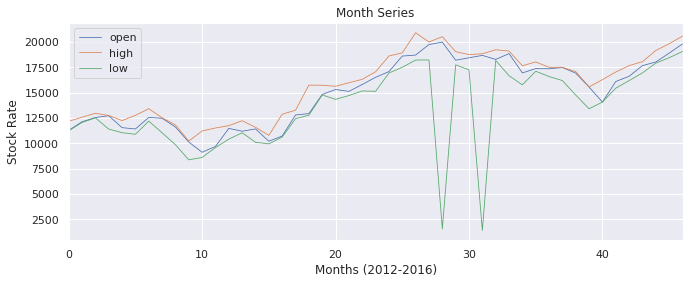

In [10]:
sns.set(rc={'figure.figsize':(11,4)})
stock_df1_1[['open','high','low']].plot(linewidth=0.8, title='Month Series')
plt.xlabel('Months (2012-2016)')
plt.ylabel('Stock Rate')

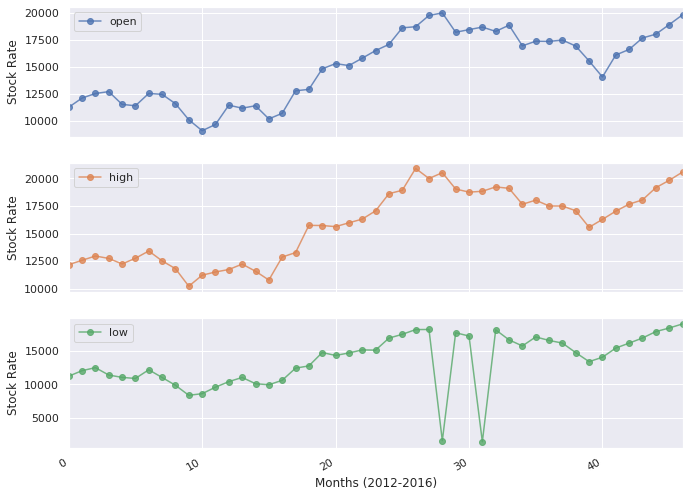

In [11]:
cols_plot = ['open', 'high','low']
axes = stock_df1_1[cols_plot].plot(marker='o', alpha=0.8, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Stock Rate')
    ax.set_xlabel('Months (2012-2016)')

#### Box Pots

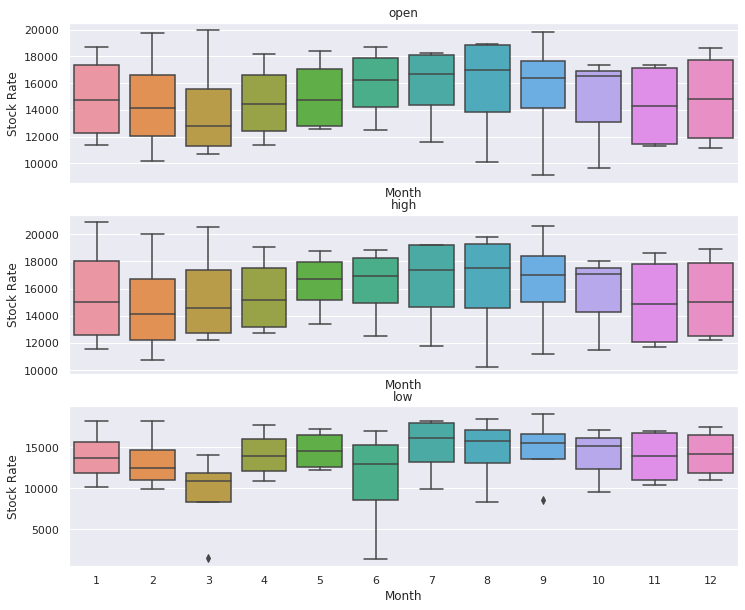

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.boxplot(data=stock_df1_1, x='Month', y=name, ax=ax)
    ax.set_ylabel('Stock Rate')
    ax.set_title(name)

#### Heat Map

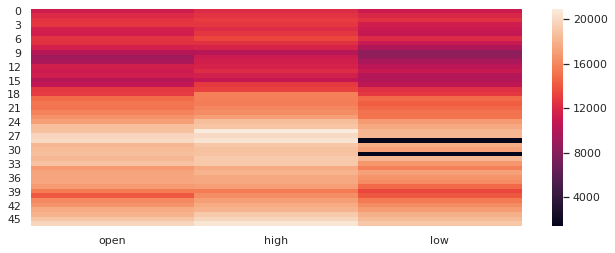

In [13]:
sns.heatmap(stock_df1_1[['open','high','low']])

#### Histograms and Curve Distribution

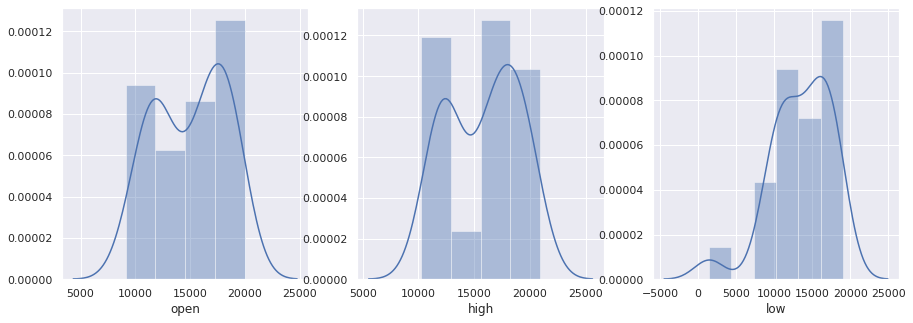

In [14]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.distplot(stock_df1_1[name], ax=ax)

#### Correlation

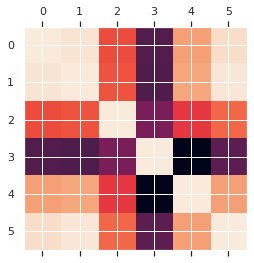

In [15]:
plt.matshow(stock_df1_1.corr())
plt.show()

#### Scatter Plot

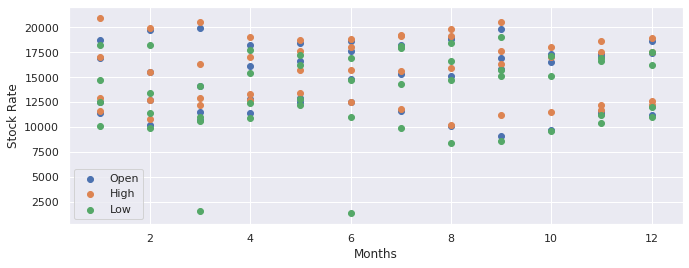

In [16]:
plt.scatter(stock_df1_1['Month'],stock_df1_1['open'])
plt.scatter(stock_df1_1['Month'],stock_df1_1['high'])
plt.scatter(stock_df1_1['Month'],stock_df1_1['low'])
plt.legend(['Open','High','Low'])
plt.xlabel('Months')
plt.ylabel('Stock Rate')
plt.show()

#### Trend Curve

Text(0.5, 0, 'Months')

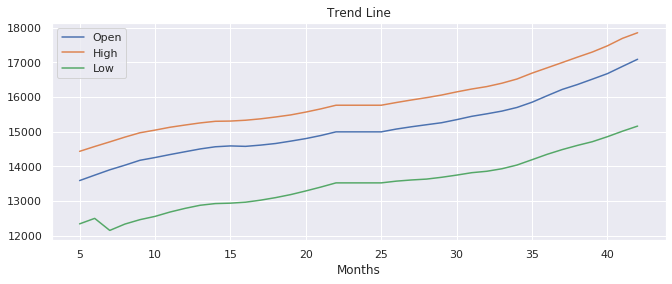

In [17]:
plt.plot(stock_df1_1['open'].rolling(window=50, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['high'].rolling(window=50, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['low'].rolling(window=50, center=True, min_periods=30).mean())
plt.legend(['Open','High','Low'])
plt.title('Trend Line')
plt.xlabel('Months')

## Splitting Data into Train/Test

In [18]:
def train_test_data(data):
    x = np.array(data.iloc[:,:]) # selecting features from data
    y = np.array(data.iloc[:,-1])  # selecting features from data
    
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle= False)
    
    return (x_train, x_test, y_train, y_test)

In [19]:
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_data(stock_df1_1)

In [20]:
x_train_df1.shape

(37, 6)

In [21]:
y_train_df1.shape

(37,)

## Vector Auto Regression

In [22]:
# training model
var = VAR(endog=x_train_df1)
var_fit = var.fit()

In [23]:
# predicting test set
prediction = var_fit.forecast(var_fit.y, steps=len(x_test_df1))

/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [24]:
# SAMPPLE test prediction
print('Predicted: %.2f' %prediction[0,5])
print('True Value: %.2f' %y_test_df1[0])

Predicted: 17949.58
True Value: 16904.15


### Evaluation

In [25]:
# printing different evaluation metrics
print('R_2 Score: %.7f' %r2_score(y_test_df1, prediction[:,5]))
print('Mean Absolute Error: %.7f' %mean_absolute_error(y_test_df1, prediction[:,5]))
print('Mean Square Error: %.7f' %mean_squared_error(y_test_df1, prediction[:,5]))
print('Root Mean Square Error: %.7f' %np.sqrt(mean_squared_error(y_test_df1, prediction[:,5])))

R_2 Score: -1.9627683
Mean Absolute Error: 2755.3519565
Mean Square Error: 8655302.9269625
Root Mean Square Error: 2941.9896205


###  Plots

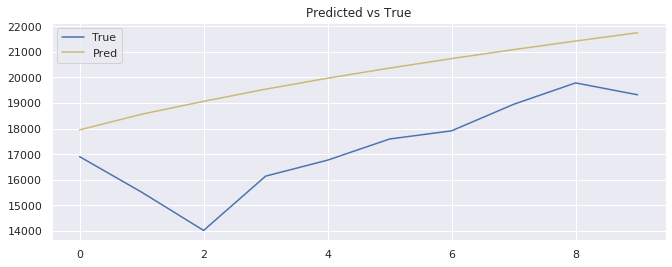

In [26]:
plt.plot(y_test_df1[0:500], 'b')
plt.plot( prediction[0:500,5], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.show()

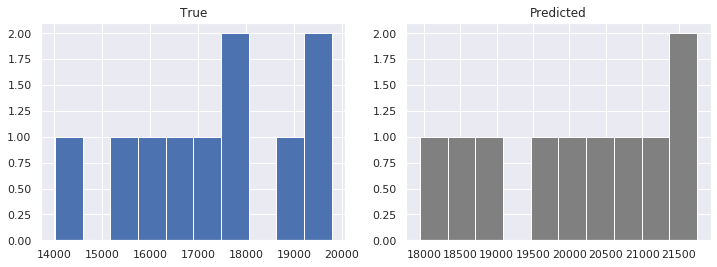

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_test_df1)
plt.title('True')

plt.subplot(1,2,2)
plt.hist(prediction[:,5], color='grey')
plt.title('Predicted')
plt.show()

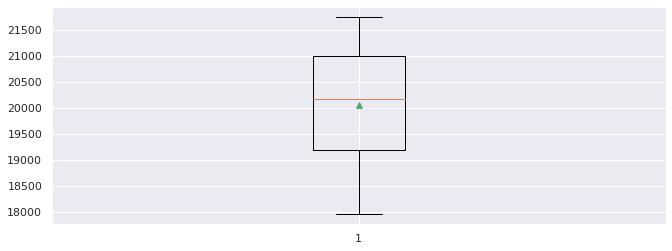

In [28]:
plt.boxplot(prediction[:,5], showmeans=True)
plt.show()